# Dual Recall data fitting

We will first try to fit the summary statistics, and then check if we can fit the loglikelihoods directly.

This should also let us debug likelihood fitting.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import experimentlauncher
import load_experimental_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import plots_experimental_data
import utils
%matplotlib inline

## Checking Dual Recall data

In [2]:
data_dualrecall = load_experimental_data.load_data_dualrecall(fit_mixture_model=True)
data_pd = data_dualrecall['panda']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/DualRecall_Bays/em_dualrecall_allitems.pickle


Need to be careful with conditions...


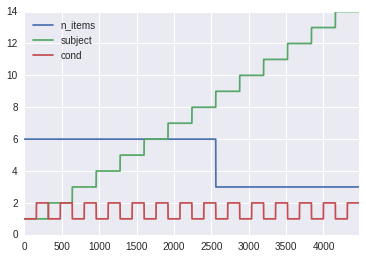

In [3]:
data_pd[['n_items', 'subject', 'cond']].plot()
print 'Need to be careful with conditions...'

## Reloading random fit_mixturemodel samples from model

Hopefully they get something interesting, let's see.

In [4]:
%cd /Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel/
%run reloader_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py

[Errno 2] No such file or directory: '/Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel/'
/nfs/data3/lmatthey/visual_working_mem/dualrecall_fitmixturemodel
Reloader data generated from  generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
Running  /nfs/data3/lmatthey/visual_working_mem/dualrecall_fitmixturemodel/reloader_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
/nfs/data3/lmatthey/visual_working_mem/dualrecall_fitmixturemodel/generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615_numrepetitions3/generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615_numrepetitions3-launcher_do_fi

In [5]:
#### SETUP
#
# savedata = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [6]:
# Extract data
result_em_fits = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_dist_dualrecall_angle = np.array(data_pbs.dict_arrays['result_dist_dualrecall_angle']['results_flat'])
result_dist_dualrecall_angle_emmixt_KL = np.array(data_pbs.dict_arrays['result_dist_dualrecall_angle_emmixt_KL']['results_flat'])
result_dist_dualrecall_colour = np.array(data_pbs.dict_arrays['result_dist_dualrecall_colour']['results_flat'])
result_dist_dualrecall_colour_emmixt_KL = np.array(data_pbs.dict_arrays['result_dist_dualrecall_colour_emmixt_KL']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_em_fits']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_em_fits']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

def str_best_params(best_i, result_dist_to_use):
    return ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [7]:
# Load ground truth
data_dualrecall = load_experimental_data.load_data_dualrecall(fit_mixture_model=True)

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/DualRecall_Bays/em_dualrecall_allitems.pickle


In [8]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1
result_parameters_flat = result_parameters_flat[filter_data]

result_em_fits = result_em_fits[filter_data]
result_dist_dualrecall_angle = result_dist_dualrecall_angle[filter_data]
result_dist_dualrecall_angle_emmixt_KL = result_dist_dualrecall_angle_emmixt_KL[filter_data]
result_dist_dualrecall_colour = result_dist_dualrecall_colour[filter_data]
result_dist_dualrecall_colour_emmixt_KL = result_dist_dualrecall_colour_emmixt_KL[filter_data]

all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]

Size post-filter:  517


In [9]:
# Compute lots of averages over the repetitions
result_em_fits_avg = utils.nanmean(result_em_fits, axis=-1)
result_dist_dualrecall_angle_avg = utils.nanmean(result_dist_dualrecall_angle, axis=-1)
result_dist_dualrecall_angle_emmixt_KL_avg = utils.nanmean(result_dist_dualrecall_angle_emmixt_KL, axis=-1)
result_dist_dualrecall_colour_avg = utils.nanmean(result_dist_dualrecall_colour, axis=-1)
result_dist_dualrecall_colour_emmixt_KL_avg = utils.nanmean(result_dist_dualrecall_colour_emmixt_KL, axis=-1)

In [10]:
result_overall_dist_dualrecall_angle_avg = np.nansum(result_dist_dualrecall_angle_avg, axis=-1)
result_overall_dist_dualrecall_colour_avg = np.nansum(result_dist_dualrecall_colour_avg, axis=-1)

In [11]:
# Get the best fitting parameters
max_best_params = 10
best_params_em_angle = np.argsort(result_overall_dist_dualrecall_angle_avg)
best_params_em_colour = np.argsort(result_overall_dist_dualrecall_colour_avg)
best_params_kl_angle = np.argsort(result_dist_dualrecall_angle_emmixt_KL_avg)
best_params_kl_colour = np.argsort(result_dist_dualrecall_colour_emmixt_KL_avg)

### Angle fits

Let's check how it looks with a 3D scatter.

In [12]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [13]:
def do_scatter3d_plotly(datapoints, data_color):
    trace1 = Scatter3d(
            x= datapoints[:, 0],
            y= datapoints[:, 1],
            z= datapoints[:, 2],
            text= data_color,
            mode= 'markers',
            marker= Marker(
                color = data_color,
#                 size = 5,
                colorscale='Blackbody',
#                 cmin=col_min_log,
#                 cmax=col_max_log,
#                 cauto=True
            )
        )
    data = Data([trace1])
    layout = Layout(
        scene=Scene(
            xaxis=XAxis(
                title=parameter_names_sorted[0],
            ),
            yaxis=YAxis(
                title=parameter_names_sorted[1],
            ),
            zaxis=ZAxis(
                title=parameter_names_sorted[2],
            )
        )
    )
    fig = Figure(data=data, layout=layout)
    
    return fig

In [14]:
py.iplot(do_scatter3d_plotly(result_parameters_flat, np.log(result_overall_dist_dualrecall_angle_avg)))

In [15]:
[str_best_params(best_ind, result_overall_dist_dualrecall_angle_avg) for best_ind in best_params_em_angle[:max_best_params]]

['M 151.0000 ratio_conj 0.8013 sigmax 0.1653 >> 0.096206',
 'M 141.0000 ratio_conj 0.8582 sigmax 0.1786 >> 0.263715',
 'M 53.0000 ratio_conj 0.9245 sigmax 0.0520 >> 0.314718',
 'M 68.0000 ratio_conj 0.9412 sigmax 0.0489 >> 0.442430',
 'M 107.0000 ratio_conj 0.7570 sigmax 0.1106 >> 0.534915',
 'M 116.0000 ratio_conj 0.8621 sigmax 0.1456 >> 0.559484',
 'M 99.0000 ratio_conj 0.8182 sigmax 0.1389 >> 0.733813',
 'M 95.0000 ratio_conj 0.8526 sigmax 0.1477 >> 0.763687',
 'M 164.0000 ratio_conj 0.8780 sigmax 0.2415 >> 0.824932',
 'M 109.0000 ratio_conj 0.7431 sigmax 0.1133 >> 0.837666']

In [16]:
weighting_power = 1.0
weighting_em = 4.
weighting_kl = 1.
weighting_sum = weighting_em + weighting_kl
weighting_em /= weighting_sum
weighting_kl /= weighting_sum

best_score = np.inf
best_param_total = -1
for param_ind in np.arange(best_params_kl_angle.size):
    curr_score = weighting_em*(np.where(best_params_em_angle == param_ind)[0][0])**weighting_power  \
                  + weighting_kl*(np.where(best_params_kl_angle == param_ind)[0][0])**weighting_power
                  
    if curr_score < best_score:
        best_param_total = best_params_kl_angle[np.where(best_params_kl_angle == param_ind)[0][0]]
        best_score = curr_score

print best_param_total, curr_score, np.where(best_params_em_angle == best_param_total)[0][0], np.where(best_params_kl_angle == best_param_total)[0][0]


199 196.8 0 19


#### BEST FIT FOR ANGLE ARE:

In [17]:
print result_em_fits_avg[best_param_total]
print str_best_params(best_param_total, result_overall_dist_dualrecall_angle_avg)
print '\n Experimental fits: \n ', '\n  '.join(["%s: %s" % (k, data_dualrecall['em_fits_angle_nitems']['mean'][6][k]) \
                                          for k in ('kappa', 'mixt_target', 'mixt_nontargets', 'mixt_random', 'train_LL', 'bic')])

[7.464697728791386 0.5843741983106588 0.41276983601760614
 0.0028559656717349804 -250.50413727010223 543.3948134725888]
M 151.0000 ratio_conj 0.8013 sigmax 0.1653 >> 0.096206

 Experimental fits: 
  kappa: 7.8066772774
  mixt_target: 0.521829627402
  mixt_nontargets: 0.455046102828
  mixt_random: 0.0231242697702
  train_LL: -200.971695913
  bic: 441.624800656


### Colour fits


In [19]:
[str_best_params(best_ind, result_overall_dist_dualrecall_colour_avg) for best_ind in best_params_em_colour[:max_best_params]]

['M 68.0000 ratio_conj 0.9412 sigmax 0.4479 >> 0.404056',
 'M 49.0000 ratio_conj 1.0000 sigmax 0.4844 >> 0.450625',
 'M 44.0000 ratio_conj 0.8182 sigmax 0.4471 >> 0.566378',
 'M 20.0000 ratio_conj 0.8000 sigmax 0.4160 >> 0.573728',
 'M 36.0000 ratio_conj 1.0000 sigmax 0.4553 >> 0.578570',
 'M 25.0000 ratio_conj 1.0000 sigmax 0.3951 >> 0.599065',
 'M 16.0000 ratio_conj 1.0000 sigmax 0.3900 >> 0.650742',
 'M 29.0000 ratio_conj 0.8621 sigmax 0.4474 >> 0.660980',
 'M 94.0000 ratio_conj 0.6809 sigmax 0.4947 >> 0.672682',
 'M 42.0000 ratio_conj 0.8571 sigmax 0.4932 >> 0.698710']

In [20]:
weighting_power = 2.0
weighting_em = 1.
weighting_kl = 1.
weighting_sum = weighting_em + weighting_kl
weighting_em /= weighting_sum
weighting_kl /= weighting_sum

best_score = np.inf
best_param_colour_total = -1
for param_ind in np.arange(best_params_kl_colour.size):
    curr_score = weighting_em*(np.where(best_params_em_colour == param_ind)[0][0])**weighting_power  \
                  + weighting_kl*(np.where(best_params_kl_colour == param_ind)[0][0])**weighting_power
                  
    if curr_score < best_score:
        best_param_colour_total = best_params_kl_colour[np.where(best_params_kl_colour == param_ind)[0][0]]
        best_score = curr_score

print best_param_colour_total, curr_score, np.where(best_params_em_colour == best_param_colour_total)[0][0], np.where(best_params_kl_colour == best_param_colour_total)[0][0]


437 96492.5 27 181


In [81]:
py.iplot(do_scatter3d_plotly(result_parameters_flat, np.log(result_overall_dist_dualrecall_colour_avg)))

#### Best fits for colours are:

In [21]:
print result_em_fits_avg[best_param_colour_total]
print str_best_params(best_param_colour_total, result_overall_dist_dualrecall_colour_avg)

print '\n Experimental fits: \n ', '\n  '.join(["%s: %s" % (k, data_dualrecall['em_fits_colour_nitems']['mean'][6][k]) \
                                          for k in ('kappa', 'mixt_target', 'mixt_nontargets', 'mixt_random', 'train_LL', 'bic')])

[1.8590778514561384 0.450776285869771 0.5486278940164214
 0.0005958201138076901 -341.6335333451734 725.6536056227311]
M 70.0000 ratio_conj 0.9143 sigmax 0.3289 >> 0.855203

 Experimental fits: 
  kappa: 1.30075558845
  mixt_target: 0.773999666927
  mixt_nontargets: 0.181215878221
  mixt_random: 0.0447844548515
  train_LL: -237.628091566
  bic: 514.902700403


** => Quite horrible fits... **

Again similar issue as in earlier fits:

It's really hard to get low $\kappa$ with high mixt_target, because increasing $\sigma_x$ leads to increased chance of mistakes...

The weighting shows this effect quite nicely, either the _em or the _colour best param is getting chosen in the overall best parameter determination

## Pandas + Seaborn plots


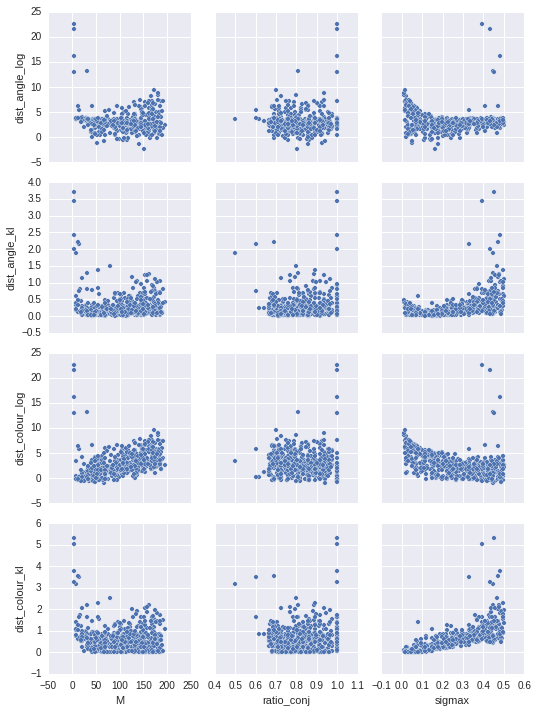

In [58]:
df_best_fits = pd.DataFrame({'M': result_parameters_flat[:, 0],
                                'ratio_conj': result_parameters_flat[:, 1],
                                'sigmax': result_parameters_flat[:, 2],
                                'dist_angle': result_overall_dist_dualrecall_angle_avg,
                                'dist_colour': result_overall_dist_dualrecall_colour_avg,
                                'dist_angle_kl': result_dist_dualrecall_angle_emmixt_KL_avg,
                                'dist_colour_kl': result_dist_dualrecall_colour_emmixt_KL_avg
                               })
df_best_fits = df_best_fits.assign(dist_angle_log = lambda x: np.log(x['dist_angle']),
                       dist_colour_log = lambda x: np.log(x['dist_colour']))

# Now big plot of all co-scatter plots!
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax'],
             y_vars=['dist_angle_log', 'dist_angle_kl', 'dist_colour_log', 'dist_colour_kl']
            )

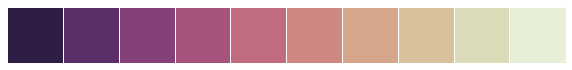

In [55]:
mycubehelix = sns.choose_cubehelix_palette()

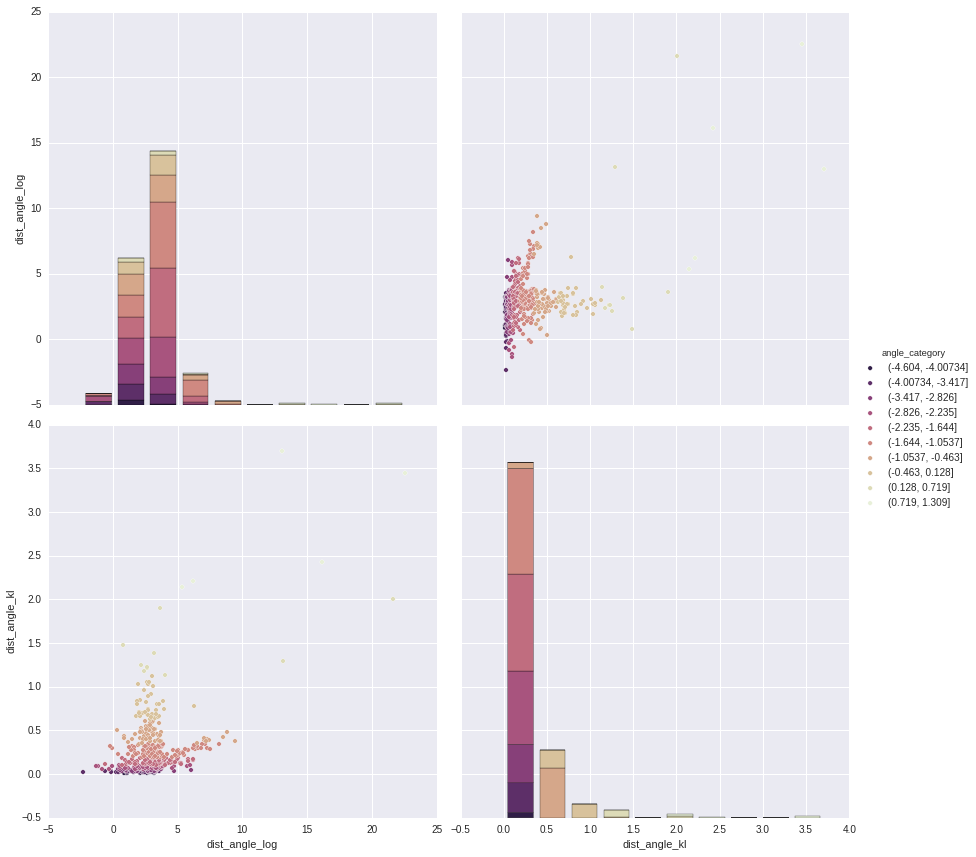

In [77]:
# Color code wrt to log(angle_kl) fit, as this seems nicely informative
sns.pairplot(df_best_fits.assign(angle_category=pd.cut(np.log(df_best_fits['dist_angle_kl']), bins=10)),
             hue='angle_category',
             palette=mycubehelix,
             vars=['dist_angle_log', 'dist_angle_kl'],
             size = 6
            )

# In this plot that doesn't help much

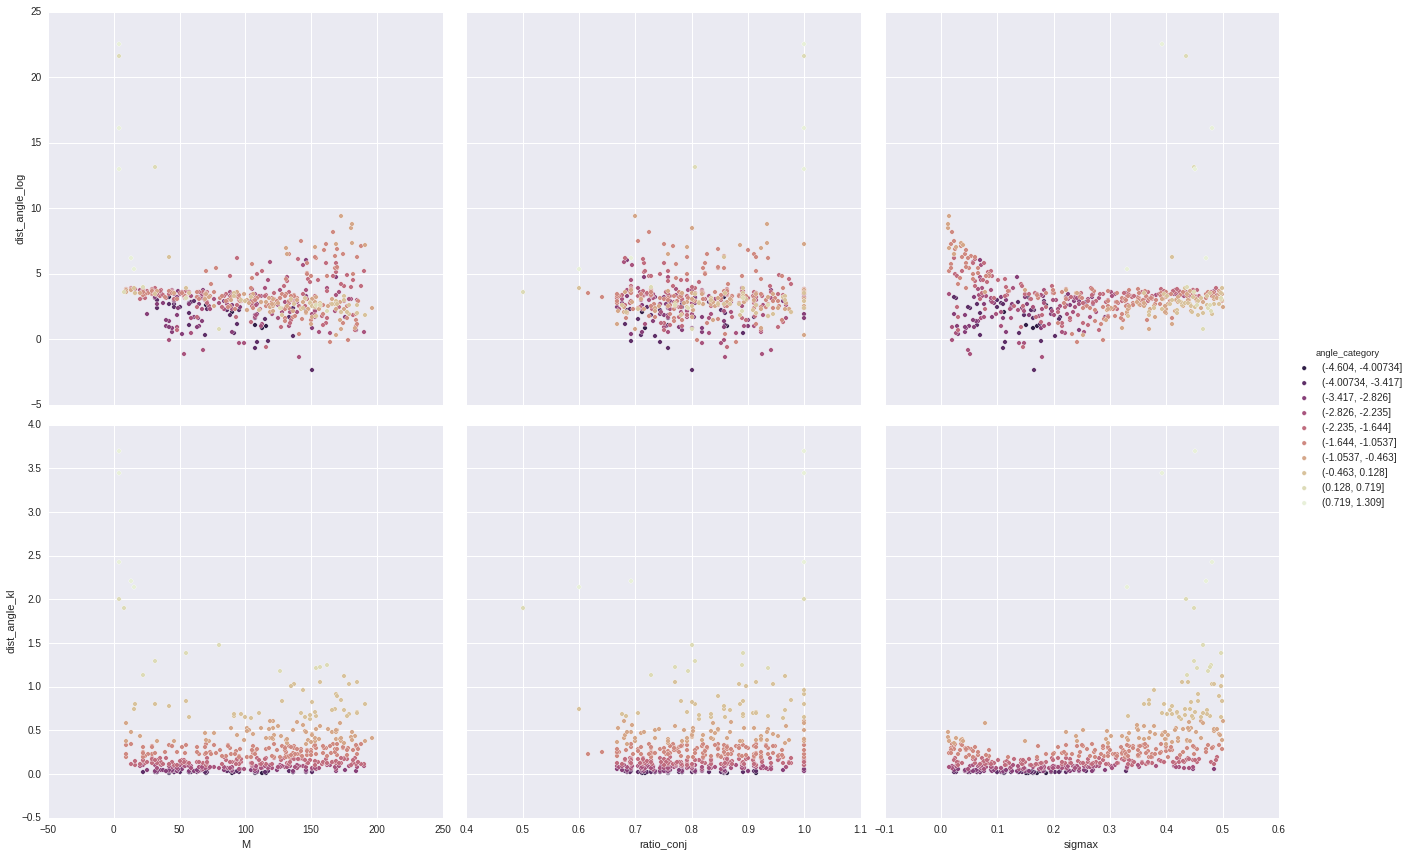

In [74]:
sns.pairplot(df_best_fits.assign(angle_category=pd.cut(np.log(df_best_fits['dist_angle_kl']), bins=10)),
             hue='angle_category',
             palette=mycubehelix,
             x_vars=['M', 'ratio_conj', 'sigmax'],
             y_vars=['dist_angle_log', 'dist_angle_kl'],
             size = 6
            )

#### => Confirms what we saw before:

There are some parameters where both Angle_EM and Angle_KL are low, i.e. where we fit both Kappa and Mixtures proportions

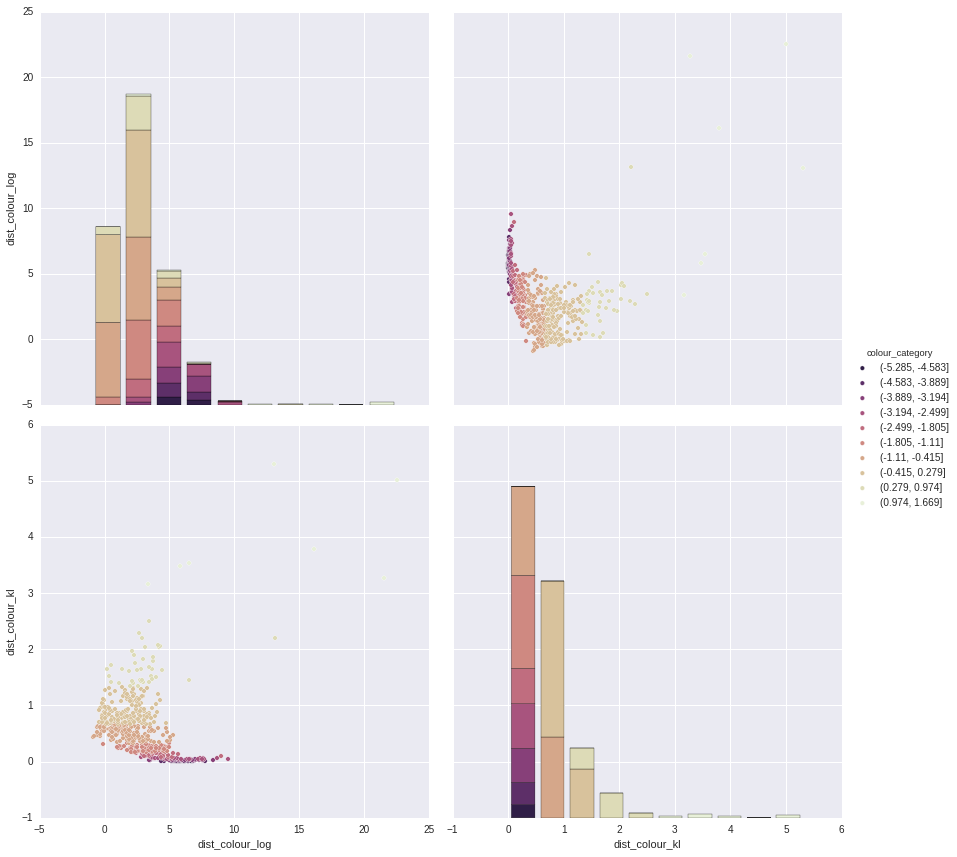

In [80]:
# Color code for Colour KL fit this time 
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_colour_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_colour_log', 'dist_colour_kl'],
             size = 6
            )

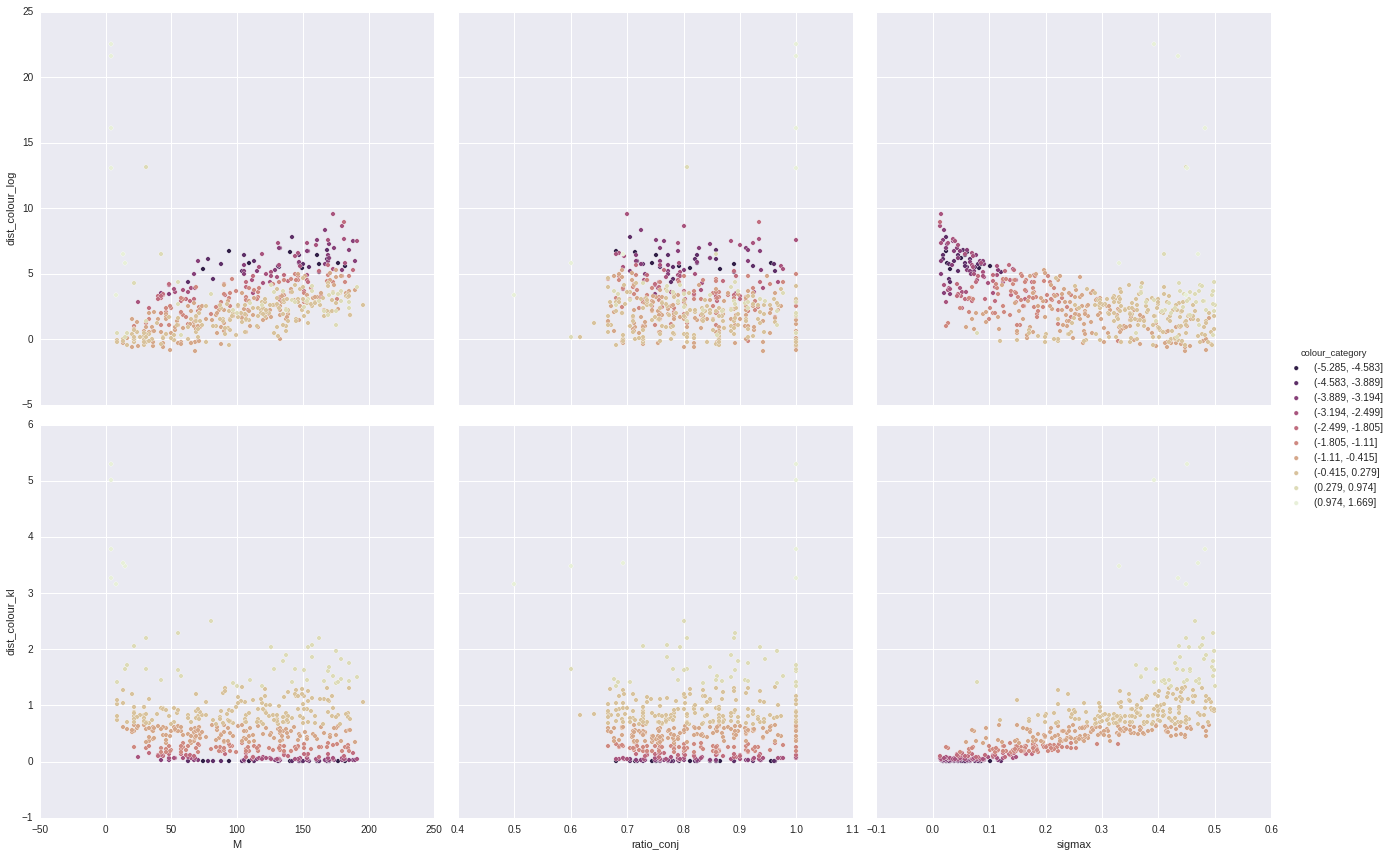

In [75]:
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_colour_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             x_vars=['M', 'ratio_conj', 'sigmax'],
             y_vars=['dist_colour_log', 'dist_colour_kl'],
             size = 6
            )

#### And once again, this is not the case for Colour fits.

Parameters which are good for one metric are not that great for the other.

What we are lacking now is the fact that those two features are encoded simultaneously in the same population. We should store actual values, with possible different number of neurons per feature dimension (simplest implementation, keeping the receptive width optimally set).

If that works, then we could perhaps fit everything nicer, I don't know.